# Preparing the training images

### Untarring the training images

In [70]:
import tarfile
import os
from tqdm import tqdm
import shutil
import numpy as np
from PIL import Image, UnidentifiedImageError
import random
import matplotlib.pyplot as plt
import h5py
import zarr
from multiprocessing import Pool

In [18]:
random.seed(234234)

In [3]:
directory = "./images/ILSVRC2010_images_train/"

if os.path.exists(directory):
    # filenames = [f for root, dirs, f in os.walk(directory)][0]
    filenames = [f for f in os.listdir(directory) if f.endswith('.tar')]

    for i in tqdm(filenames):
        with tarfile.open(f"{directory}/{i}", 'r') as tar:
            tar.extractall(path="./images/training_images/")
else:
    print("Directory doesn't exist.\nYou are likely done with this step.")

Directory doesn't exist.
You are likely done with this step.


In [3]:
# deleting the folder with the tar files to free up space
# using shutil instead of  os, apparently safer than using the shell
if os.path.exists(directory):
    shutil.rmtree(directory)
    print(f"Deleted directory: {directory}")
else:
    print(f"Directory does not exist: {directory}")

Directory does not exist: ./images/ILSVRC2010_images_train/


### Replacing patch images

The Image Net folks have provided an additional folder with images to be replaced in all the three datasets. In the patch images readme, they instruct to "simply replace the old images with the new images in this folder." So, I will do the same below.

In [31]:
destination = "./images/training_images/"
patch_images_train = "./images/patch_images/train/"

if os.path.exists(patch_images_train):
    filepath_all_patch_train = []
    filenames = []
    
    for i in os.listdir(patch_images_train):
        if i[0] == "n":
            for j in os.listdir(patch_images_train + i):
                filepath_all_patch_train.append(patch_images_train + i + "/" + j)
                filenames.append(j)
    
    # print(filepath_all_patch_train)

In [38]:
len(filenames) == len(filepath_all_patch_train)

True

In [39]:
files_removed = 0

for name, patch_image in tqdm(zip(filenames, filepath_all_patch_train)):
    if os.path.exists(destination + name):
        os.remove(destination + name)
        files_removed += 1
    
    shutil.move(
        patch_image, 
        destination
    )

970it [00:00, 1513.60it/s]


In [40]:
print("Files removed:", files_removed)

Files removed: 969


_Right now, I want to dive into training the model as soon as possible, so I will replace the validation and testing patch images later._ It should be straightforwad because the code will be the same as above.

### Rescaling and cropping the images

In the paper, the authors do basically three things:
1. If the image is square, then downsampling it to 256 x 256
   - "Given a rectangular image, we first rescaled the image such that the shorter side was of length 256, and thencropped out the central 256×256 patch from the resulting image."
3. "Subtracting the mean activity over the training set from each pixel"

In [3]:
training_images_path = "./images/training_images/"

In [32]:
image_names_path = [training_images_path + f for f in os.listdir(training_images_path)]

In [38]:
orig_image_count = len(image_names_path)
print(
    orig_image_count,
    image_names_path[:5],
)

1261406 ['./images/training_images/n03982430_20160.JPEG', './images/training_images/n01795545_1346.JPEG', './images/training_images/n12052787_9724.JPEG', './images/training_images/n01775062_2146.JPEG', './images/training_images/n03042490_1919.JPEG']


In [34]:
sample_image = Image.open(image_names_path[0])
print(sample_image.format, sample_image.size, sample_image.mode)

JPEG (500, 375) RGB


In [37]:
sample_image.show()

In [35]:
# checking the number of rectangular images
len([Image.open(name).size for name in image_names_path if Image.open(name).size[0] != Image.open(name).size[1]])

UnidentifiedImageError: cannot identify image file '/Users/asteroidhunter/PycharmProjects/replicatingAlexNet/images/training_images/n02487347_1956.JPEG'

In [36]:
no_good_image = Image.open("./images/training_images/n02487347_1956.JPEG")
no_good_image.show()

UnidentifiedImageError: cannot identify image file '/Users/asteroidhunter/PycharmProjects/replicatingAlexNet/images/training_images/n02487347_1956.JPEG'

Seems like at least one image is somehow corrupted. This particular image doesn't render in my OS either. There could be more corrupted images, so **side quest: removing all such corrupted images.**

In [ ]:
crappy_image_count = 0 

for i in image_names_path:
    try:
        Image.open(i)
    
    except UnidentifiedImageError:
        crappy_image_count += 1
        
        shutil.move(
            i, 
            "./images/crappy_training_images/"
        )

print(crappy_image_count, "images moved.")
print(orig_image_count - crappy_image_count, "images left.")

All that for one image...

In [12]:
# updating the list of valid images
training_images_path = "./images/training_images/"
image_names_path = [training_images_path + f for f in os.listdir(training_images_path)]

new_image_count = len(image_names_path)
print(
    new_image_count,
    image_names_path[:5],
)

1261405 ['./images/training_images/n03982430_20160.JPEG', './images/training_images/n01795545_1346.JPEG', './images/training_images/n12052787_9724.JPEG', './images/training_images/n01775062_2146.JPEG', './images/training_images/n03042490_1919.JPEG']


In [48]:
# checking the number of rectangular images
len([Image.open(name).size for name in image_names_path if Image.open(name).size[0] != Image.open(name).size[1]])

1191973

#### Testing the rescaling and cropping on a small portion of the training set

In [20]:
# creating a folder to copy some images and test the rescaling + cropping code
try:
    os.mkdir("./images/image_cropping_test/")
except FileExistsError:
    pass

try:
    os.mkdir("./images/image_cropping_test_out/")
except FileExistsError:
    pass

In [ ]:
for i in random.choices(image_names_path, k=500):
    shutil.copy(
            i, 
            "./images/image_cropping_test"
        )

In [4]:
cropping_images_path = "./images/image_cropping_test/"
cropping_names_only = [f for f in os.listdir(cropping_images_path)]
cropping_names_path = [cropping_images_path + f for f in os.listdir(cropping_images_path)]
len(cropping_names_path)

500

In [5]:
# checking if there are images smaller than 256 x 256 along at least one dimension
print(
    "Images smaller than 256 x 256:", 
    len([Image.open(name).size for name in cropping_names_path if Image.open(name).size[0] < 256 and Image.open(name).size[1] < 256]),
    "\n"
    "Images smaller than 256 x 256 along at least one dimension:",
    len([Image.open(name).size for name in cropping_names_path if Image.open(name).size[0] < 256 or Image.open(name).size[1] < 256]),
)

Images smaller than 256 x 256: 55 
Images smaller than 256 x 256 along at least one dimension: 86


The authors in the paper do not mention how they treated images which were smaller than 256 x 256, since these would need to be upscaled. I am going to make the assumption that such images were indeed upsampled.

I am unsure about the optimal resampling strategy here. Upscaling would lead to blurring, and there are ways to avoid the blur. Assuming the 500 above is a random sample, it means ~10% of images are smaller than 256 x 256, which is non-trivial amount, and I don't know how resampling with different algorithms would affect the model's performance. This could be empirically tested by having two sets of training sets with blurred and less or unblurred images.

**I will go with upscaling with resampling to avoid blur and preserve detail.**

Below, I was testing how the different resampling algorithms perform; lanczos seems like a sound choice. I also found [this table in the official doc](https://pillow.readthedocs.io/en/stable/handbook/concepts.html#filters-comparison-table) comparing performance vs. quality.

In [10]:
#n = 150
#some_image = Image.open(cropping_names_path[n])

# nearest_image = some_image.resize((256, 256), Image.NEAREST)
# bilinear_image = some_image.resize((256, 256), Image.BILINEAR)
# bicubic_image = some_image.resize((256, 256), Image.BICUBIC)
# lanczos_image = some_image.resize((256, 256), Image.LANCZOS)

# # save the downscaled images for comparison
# nearest_image.save('./images/image_cropping_test_out/nearest_image.jpg')
# bilinear_image.save('./images/image_cropping_test_out/bilinear_image.jpg')
# bicubic_image.save('./images/image_cropping_test_out/bicubic_image.jpg')
# lanczos_image.save('./images/image_cropping_test_out/lanczos_image.jpg')
# shutil.copy(cropping_names_path[n], "./images/image_cropping_test_out/original_image.jpg")

In [3]:
def process_images_for_alexnet(
    image,
    image_name,
    location_to_save,
    new_width=256,
    new_height=256,
    
):
    one_image = Image.open(image)
    width, height = one_image.size

    # the three situations, which ended up being kind of redundant
    large_square_image = width >= 256 and height >= 256 and width == height
    small_square_image = width < 256 and height < 256 and width == height
    rectangular_image = width != height

    if rectangular_image:
        
        # rescaling such that the smaller side is 256 pixels in length
        if width < height:
            width_ratio = new_width / width
            scaled_height = int(height * width_ratio)
            transformed_image = one_image.resize((new_width, scaled_height), Image.LANCZOS)
        else:
            height_ratio = new_height / height
            scaled_width = int(width * height_ratio)
            transformed_image = one_image.resize((scaled_width, new_height), Image.LANCZOS)

        width_transformed, height_transformed = transformed_image.size
        # cropping the 256 x 256 portion in the middle
        left = (width_transformed - new_width) // 2
        top = (height_transformed - new_height) // 2
        right = left + new_width
        bottom = top + new_height
    
        transformed_image = transformed_image.crop((left, top, right, bottom))
    
    elif large_square_image or small_square_image:
        # here, the first argument is size=(W, H) and the second one is resample
        transformed_image = one_image.resize((256, 256), Image.LANCZOS)

    transformed_image.save(f"./{location_to_save}/{image_name}")

In [26]:
for image_path, name in tqdm(zip(cropping_names_path, cropping_names_only)):
    process_images_for_alexnet(
        image_path,
        name,
        location_to_save="./images/image_cropping_test_out/",
        new_width=256,
        new_height=256,
    )

500it [00:01, 273.12it/s]


In [6]:
transformed_names_path = [
    "./images/image_cropping_test_out/" + f for f in os.listdir("./images/image_cropping_test_out/")
    if f.endswith('.JPEG')
]    
len(transformed_names_path)

500

#### Spot checking a few images to see if the rescaling and cropping happeneded properly

In [20]:
iter_cropping_names_path = iter(cropping_names_path)
iter_transformed_names_path = iter(transformed_names_path)

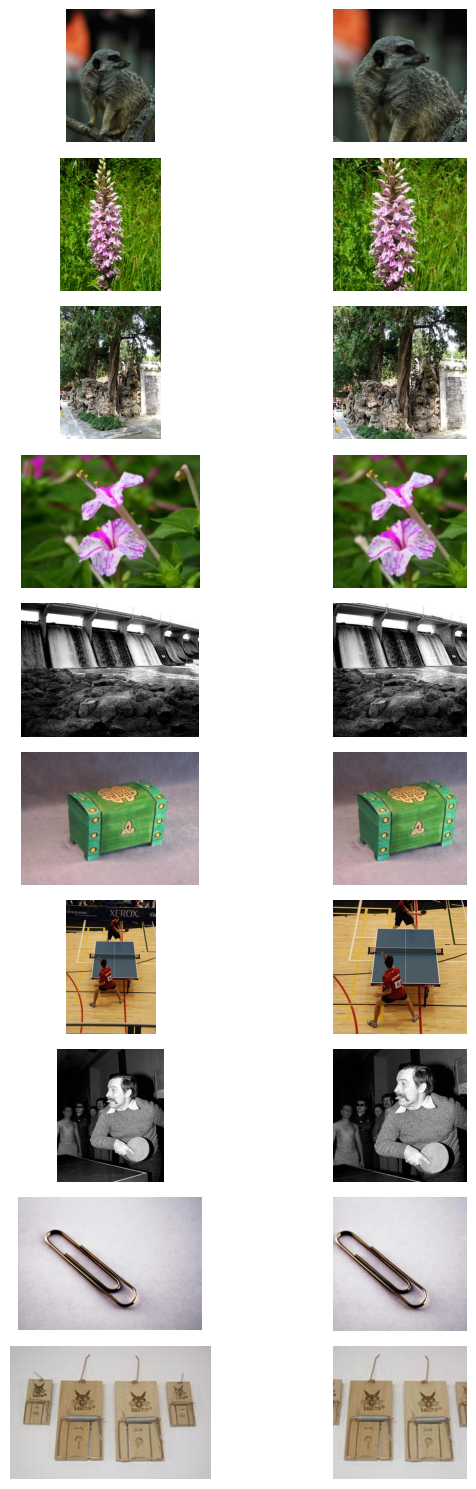

In [27]:
fig, ax = plt.subplots(10, 2, figsize=(20, 15))

for n, original_image, transformed_image in zip(
    range(10), 
    [next(iter_cropping_names_path) for _ in range(10)], 
    [next(iter_transformed_names_path) for _ in range(10)],
):
    ax[n, 0].imshow(Image.open(original_image))
    ax[n, 1].imshow(Image.open(transformed_image))
    
    ax[n, 0].axis('off')
    ax[n, 1].axis('off')

plt.subplots_adjust(wspace=-1, hspace=0) 
plt.tight_layout()
plt.show()

#### Next, I will subtract the mean activity from each image.

First, checking if all images have three channels.

uh oh
(256, 256)
./images/image_cropping_test_out/n02508021_10335.JPEG
(256, 256, 3)


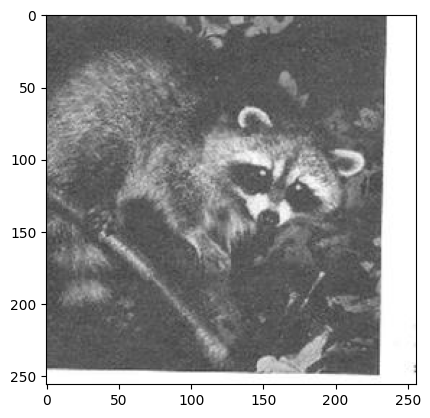

In [53]:
for i in range(500):
    image = Image.open(transformed_names_path[i])
    image_as_array = np.asarray(image)
    
    if image_as_array.shape != (256, 256, 3):
        print("uh oh")
        print(image_as_array.shape)
        print(transformed_names_path[i])
        plt.imshow(image_as_array)

        # duplicating the grayscale across three channels
        three_channel_image = Image.merge("RGB", (image, image, image))
        plt.imshow(np.asarray(three_channel_image))
        print(np.asarray(three_channel_image).shape)

        # saving the new image by overwriting te old one
        three_channel_image.save(transformed_names_path[i])

Seems like one image is black and white, there may be more such images in the full training set, so I will duplicate the grayscale matrices across the three channels before performing the mean activity substraction.

In [54]:
# rerunning the same loop, this time, it should never trigger the if-statement block

for i in range(500):
    image = Image.open(transformed_names_path[i])
    image_as_array = np.asarray(image)
    
    if image_as_array.shape != (256, 256, 3):
        print("uh oh")
        print(image_as_array.shape)
        print(transformed_names_path[i])
        plt.imshow(image_as_array)

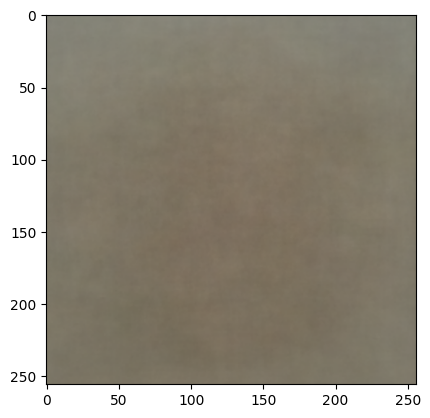

In [8]:
mean_activity_image_sample = np.mean([np.asarray(Image.open(i)) for i in transformed_names_path], axis=0)
plt.imshow(np.int_(mean_activity_image_sample))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-137..160].


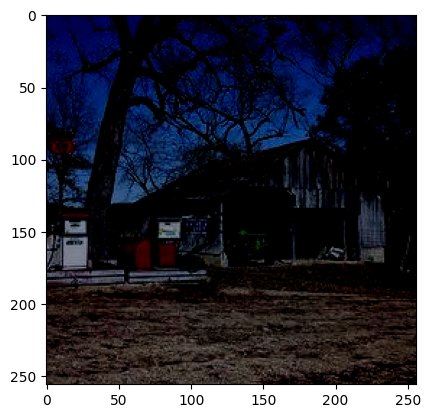

In [237]:
image_number = 0
sample_substracted_image = np.asarray(Image.open(transformed_names_path[image_number])) - mean_activity_image_sample
plt.imshow(np.int_(sample_substracted_image))

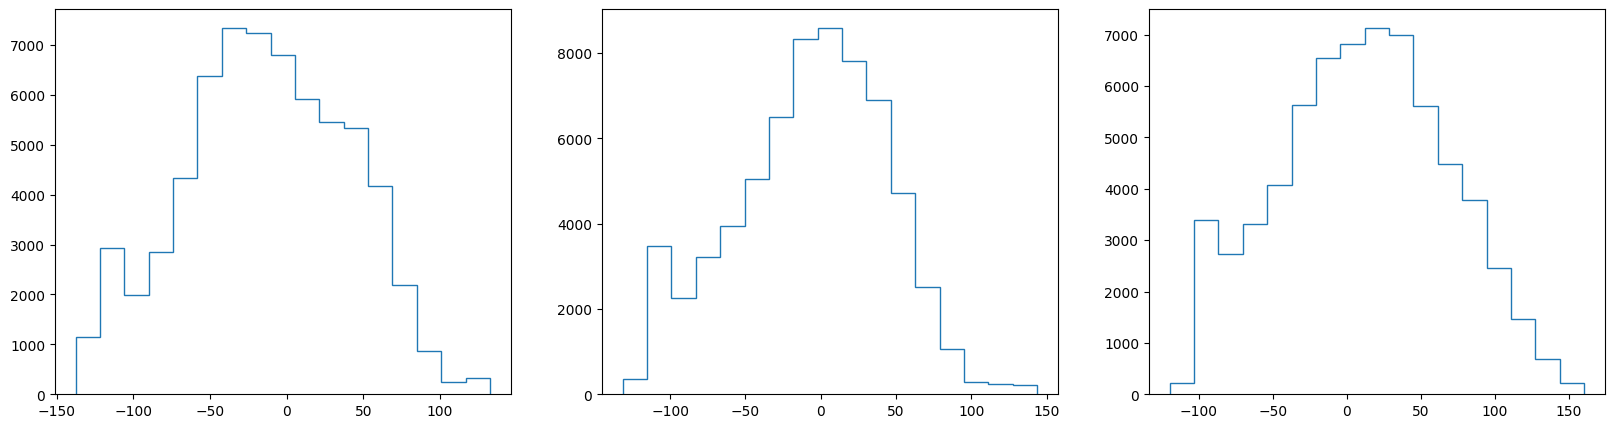

In [238]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.flatten()

for i in range(3):
    ax[i].hist(sample_substracted_image[:,:,i].flatten(), bins="sturges", histtype="step")

plt.show()

As expected the values are now roughly centered around zero which is apparently better for training.

(I should mention that the first image seems to unusally well centered at zero. The historgram for some other images are skewed).

In [117]:
# was sanity checking that there wasn't any misalignment of names

#for i in range(500):
#    if cropping_names_only[i] not in transformed_names_path[i]:
#        print("ughhhhh")
        

In [12]:
try:
    os.mkdir("./images/subtracted_images_directory_test/")
except FileExistsError:
    pass

subtracted_images_directory_test = "./images/subtracted_images_directory_test/"

for i in range(500):
    image = Image.open(transformed_names_path[i])
    subtracted_image = np.asarray(image) - mean_activity_image_sample
    name_of_output_saved = subtracted_images_directory_test + cropping_names_only[i][:-5] # + ".npy"
    # np.savez_compressed(name_of_output_saved, subtracted_image)

In [193]:
subtracted_images_test_path = [subtracted_images_directory_test + f for f in os.listdir(subtracted_images_directory_test)]
subtracted_images_test_path_iter = iter(subtracted_images_test_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-135..157].


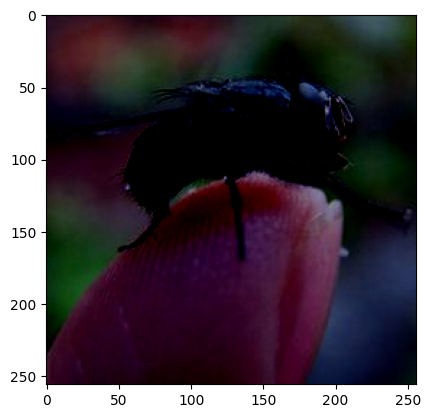

In [247]:
# spot checking if the images were saved properly
plt.imshow(
    np.int_(
        np.load(
            next(
                subtracted_images_test_path_iter
            )
        )
    )
)

(I am being cautious at each step here because after the initial pre-processing, ~~I will **replace** the transformed images **in place** of the original ones due to space constraints.~~ edit: too risky, I will create a separate output folder and then delete the original after checking if things look right.)

Saving numpy arrays seems to be much more space-intensive than JPEGs (500 images were 7.8 MB in the JPEG format, 750+ MB as `.npy`s, and ~350 MB as `.npz`s and `zarr` files. I was initially planning to save the resacled and mean activity subtracted image, and then passing that as the input while running the model. But since some pixel values are negative after the subtraction, I will have to convert them to ranges [0, 1] or [0, 255] before saving them. This seems like a redundant step, because when I pass the images as input, I would have to reconvert them to zero-centered range again. So, I will just saved the rescaled images and do the substraction + 244 x 244 sampling while passing it as the input.

Overall, this image preprocessing routine was straightforward, fun, but also annoying.

## Running the rescaling and cropping function on the entire training set

(Everything in the cell block below was copy-pasted to `preprocessing.py` and ran separately. For some reason, multiprocessing isn't able to identify the function `process_images_for_alexnet`.)

In [ ]:
def process_images_for_alexnet(
    image,
    image_name,
    location_to_save,
    new_width=256,
    new_height=256,
    
):
    for image_single, image_name_single in zip(image, image_name):

        one_image = Image.open(image_single)
        width, height = one_image.size
    
        # the three situations, which ended up being kind of redundant
        large_square_image = width >= 256 and height >= 256 and width == height
        small_square_image = width < 256 and height < 256 and width == height
        rectangular_image = width != height
    
        if rectangular_image:
            
            # rescaling such that the smaller side is 256 pixels in length
            if width < height:
                width_ratio = new_width / width
                scaled_height = int(height * width_ratio)
                transformed_image = one_image.resize((new_width, scaled_height), Image.LANCZOS)
            else:
                height_ratio = new_height / height
                scaled_width = int(width * height_ratio)
                transformed_image = one_image.resize((scaled_width, new_height), Image.LANCZOS)
    
            width_transformed, height_transformed = transformed_image.size
            
            # cropping the 256 x 256 portion in the middle
            left = (width_transformed - new_width) // 2
            top = (height_transformed - new_height) // 2
            right = left + new_width
            bottom = top + new_height
        
            transformed_image = transformed_image.crop((left, top, right, bottom))
        
        elif large_square_image or small_square_image:
            # here, the first argument is size=(W, H) and the second one is resample
            transformed_image = one_image.resize((256, 256), Image.LANCZOS)

        transformed_image.save(f"./{location_to_save}/{image_name_single}")

training_images_path = "./images/training_images/"
training_images_path_all = [training_images_path + f for f in os.listdir(training_images_path) if f.endswith(".JPEG")]
training_images_just_names = [f for f in os.listdir(training_images_path) if f.endswith(".JPEG")]

def chunkify(list_of_things, cores):
    quotient, remainder = divmod(len(list_of_things), cores)

    chunks = [list_of_things[quotient * n:quotient * (n + 1)] for n in range(cores)]
    chunks[-1].extend(list_of_things[-remainder:])

    return chunks

try:
    os.mkdir("./images/training_images_processed/")
except FileExistsError:
    pass

training_images_output_path = "./images/training_images_processed/"

if __name__ == "__main__":
    number_of_cores = 10
    
    # splitting the paths and names into n portions
    path_chunks = chunkify(training_images_path_all, number_of_cores)
    name_chunks = chunkify(training_images_just_names, number_of_cores)
    
    # list of arguments for the all the tasks
    arguments = [(path_chunks[i], name_chunks[i], training_images_output_path, 256, 256) for i in range(number_of_cores)]
    
    with Pool(number_of_cores) as pool:
        pool.starmap(process_images_for_alexnet, arguments)

## Checking if all the training images were pre-processed correctly

In [80]:
# checking the total number of images and if they are equal to the number of original training images

training_images_processed_path = [
    training_images_output_path + f for f in os.listdir(training_images_output_path)
    if f.endswith('.JPEG')
]    

print(len(training_images_processed_path))
print(len(training_images_processed_path) == len(training_images_path_all))

1261405
True


In [94]:
# checking if the dimensions of all the images are fine (although a redundant check at this point)

problem_images = []

for image_path in tqdm(training_images_processed_path):
    if Image.open(image_path).size != (256, 256):
        problem_images.append(image_path)

print("All the image sizes look good.") if len(problem_images) == 0 else print("Some images have the wrong dimension")

100%|███████████████████████████████| 1261405/1261405 [05:11<00:00, 4045.03it/s]

All the image sizes look good.


In [95]:
iter_original_training_images = iter(training_images_path_all)
iter_processed_training_images = iter(training_images_processed_path)

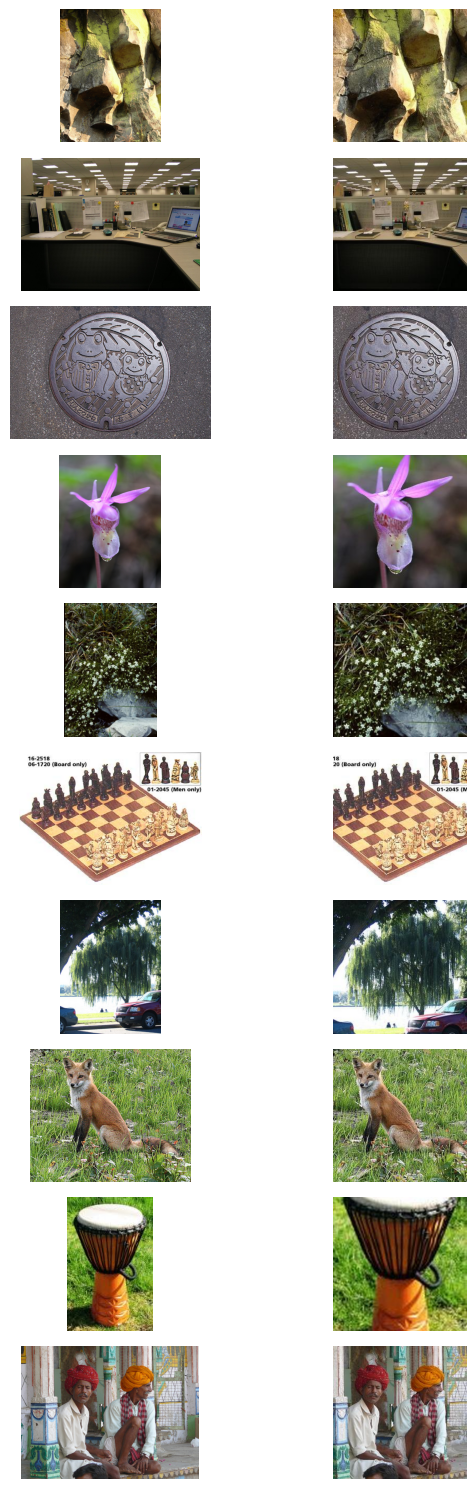

In [105]:
images_to_show = 10

fig, ax = plt.subplots(images_to_show, 2, figsize=(20, 15))

for n, original_image, transformed_image in zip(
    range(images_to_show),
    [next(iter_original_training_images) for _ in range(images_to_show)], 
    [next(iter_processed_training_images) for _ in range(images_to_show)],
):
    ax[n, 0].imshow(Image.open(original_image))
    ax[n, 1].imshow(Image.open(transformed_image))
    
    ax[n, 0].axis('off')
    ax[n, 1].axis('off')

plt.subplots_adjust(wspace=-1, hspace=0) 
plt.tight_layout()
plt.show()